In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime
from sklearn.metrics import roc_auc_score as auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
columns = ["duration",
           "protocol_type",
           "service",
           "flag",
           "src_bytes",
           "dst_bytes",
           "land",
           "wrong_fragment",
           "urgent",
           "hot",
           "num_failed_logins",
           "logged_in",
           "num_compromised",
           "root_shell",
           "su_attempted",
           "num_root",
           "num_file_creations",
           "num_shells",
           "num_access_files",
           "num_outbound_cmds",
           "is_host_login",
           "is_guest_login",
           "count",
           "srv_count",
           "serror_rate",
           "srv_serror_rate",
           "rerror_rate",
           "srv_rerror_rate",
           "same_srv_rate",
           "diff_srv_rate",
           "srv_diff_host_rate",
           "dst_host_count",
           "dst_host_srv_count",
           "dst_home_same_srv_rate",
           "dst_host_diff_srv_rate",
           "dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate",
           "dst_host_serror_rate",
           "dst_host_srv_serror_rate",
           "dst_host_rerror_rate",
           "dst_host_srv_rerror_rate",
           "label"]

In [3]:
df = pd.read_csv("/Users/shawnmccarthy/Desktop/Independent Study/IsolationForest/data/kddcup.data", sep=",", names=columns, index_col=None)
df.shape

#clean up the data
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")
df.shape

df.tail #only http attacks

<bound method NDFrame.tail of          duration protocol_type flag  src_bytes  dst_bytes  land  \
0               0           tcp   SF        215      45076     0   
1               0           tcp   SF        162       4528     0   
2               0           tcp   SF        236       1228     0   
3               0           tcp   SF        233       2032     0   
4               0           tcp   SF        239        486     0   
...           ...           ...  ...        ...        ...   ...   
4898426         0           tcp   SF        212       2288     0   
4898427         0           tcp   SF        219        236     0   
4898428         0           tcp   SF        218       3610     0   
4898429         0           tcp   SF        219       1234     0   
4898430         0           tcp   SF        219       1098     0   

         wrong_fragment  urgent  hot  num_failed_logins  ...  \
0                     0       0    0                  0  ...   
1                     0  

In [4]:
for col in df.columns:
    if df[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(df[col])
        df[col] = encoded.transform(df[col])

df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_home_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,9,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4
1,0,0,9,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4
2,0,0,9,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,4
3,0,0,9,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,4
4,0,0,9,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,4


In [5]:
anomalies = df[df["label"] != 4]
normal = df[df["label"] == 4]

for f in range(0,10):
    normal = normal.iloc[np.random.permutation(len(normal))]

novelties = pd.concat([normal[:50000], anomalies])
novelties.shape

(54045, 41)

In [6]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', 41):
    print(novelties)

         duration  protocol_type  flag  src_bytes  dst_bytes  land  \
58467           0              0     9        168       1078     0   
203232          0              0     9        231        364     0   
...           ...            ...   ...        ...        ...   ...   
4764841         0              0     9      54540       8314     0   
4764842         0              0     9      54540       8314     0   

         wrong_fragment  urgent  hot  num_failed_logins  logged_in  \
58467                 0       0    0                  0          1   
203232                0       0    0                  0          1   
...                 ...     ...  ...                ...        ...   
4764841               0       0    2                  0          1   
4764842               0       0    2                  0          1   

         num_compromised  root_shell  su_attempted  num_root  \
58467                  0           0             0         0   
203232                 0      

In [7]:
for c in columns:
    if (c != "protocol_type" and c != "flag" and c != "label"):
        novelties[c] = StandardScaler().fit_transform(novelties[c].values.reshape(-1,1))

novelties.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_home_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
58467,-0.007414,0,9,-0.211550,-0.189777,0.0,0.0,0.0,-0.210703,0.0,...,0.328756,0.197612,-0.125488,0.005130,-0.386653,-0.181465,-0.179297,-0.320743,-0.324199,4
203232,-0.007414,0,9,-0.205653,-0.234166,0.0,0.0,0.0,-0.210703,0.0,...,0.328756,0.197612,-0.125488,2.413440,0.401291,-0.181465,-0.179297,-0.320743,-0.324199,4
500036,-0.007414,0,9,-0.205185,-0.117598,0.0,0.0,0.0,-0.210703,0.0,...,0.293975,0.135553,0.307839,-0.386921,-0.583639,-0.181465,-0.179297,-0.247090,-0.248880,4
1046690,-0.007414,0,9,-0.197790,-0.237772,0.0,0.0,0.0,-0.210703,0.0,...,0.328756,0.197612,-0.125488,1.013259,-0.189667,-0.181465,-0.179297,-0.320743,-0.324199,4
1409952,-0.007414,0,1,-0.227276,-0.256796,0.0,0.0,0.0,-0.210703,0.0,...,0.328756,0.197612,-0.125488,2.413440,1.386220,-0.181465,-0.179297,3.361891,2.274299,4


In [8]:
train_x = novelties.iloc[:43000, 1:-2].values
train_y = novelties.iloc[:43000, -1].values

test_x = novelties.iloc[43000:, 1:-2].values
test_x_full = novelties.iloc[43000:].values
test_y = novelties.iloc[43000:, -1].values

In [9]:
from rbm import RBM

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
model = RBM(train_x.shape[1], 20, visible_unit_type='gauss', main_dir='./', model_name='rbm_model2.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.001, momentum = 0.95, batch_size=512, num_epochs=20, verbose=1)

Validation cost at step 0: 1.465921
Validation cost at step 1: 1.453817
Validation cost at step 2: 1.4010525
Validation cost at step 3: 1.4029335
Validation cost at step 4: 1.4219633
Validation cost at step 5: 1.4036572
Validation cost at step 6: 1.3901647
Validation cost at step 7: 1.4016823
Validation cost at step 8: 1.3898687
Validation cost at step 9: 1.4002732
Validation cost at step 10: 1.3972083
Validation cost at step 11: 1.4036243
Validation cost at step 12: 1.3906533
Validation cost at step 13: 1.3883729
Validation cost at step 14: 1.3819394
Validation cost at step 15: 1.3735157
Validation cost at step 16: 1.3830054
Validation cost at step 17: 1.3888072
Validation cost at step 18: 1.3806039
Validation cost at step 19: 1.3776238


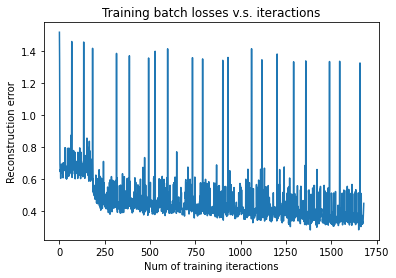

In [11]:
model.fit(train_x, validation_set=test_x)

In [12]:
for f in range(0, len(test_y)):
    if test_y[f] == 4:
        test_y[f] = 0
    else:
        test_y[f] = 1

In [13]:
test_cost = model.getFreeEnergy(test_x).reshape(-1)

INFO:tensorflow:Restoring parameters from ./rbm_model2.ckpt


In [14]:
auc(test_y, test_cost)

0.9954053328624405

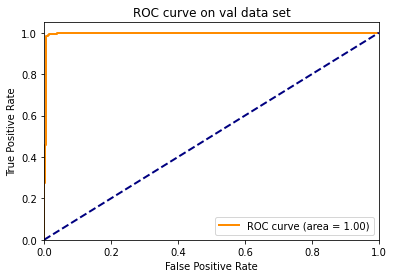

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, test_cost)

fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
roc_auc = auc(fpr_micro, tpr_micro)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on val data set')
plt.legend(loc="lower right")
plt.show()

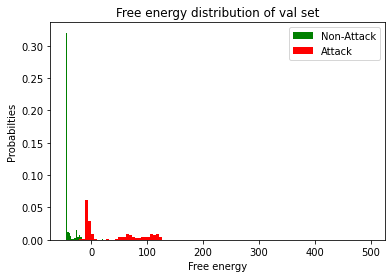

In [16]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.title('Free energy distribution of val set')
plt.xlabel('Free energy')
plt.ylabel('Probabilties')
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=1.0, label='Non-Attack')
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=1.0, label = 'Attack')

plt.legend(loc="upper right")
plt.show()

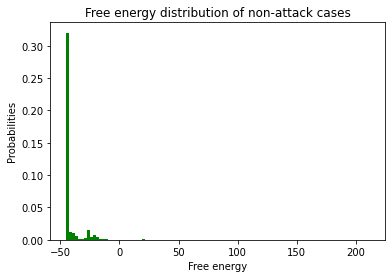

In [17]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=1)
plt.title('Free energy distribution of non-attack cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

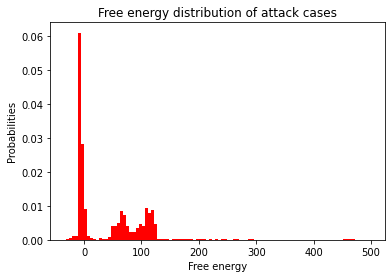

In [18]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=1)
plt.title('Free energy distribution of attack cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

In [19]:
anomaly = pd.DataFrame(test_x_full[test_y==1])
anomaly.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-0.007414,0.0,5.0,-0.227276,-0.256796,0.0,0.0,0.0,-0.210703,0.0,...,-4.088409,-6.008253,13.307636,2.581461,-0.583639,-0.122522,5.715912,1.594227,-0.324199,6.0
1,-0.007414,0.0,5.0,-0.227276,-0.256796,0.0,0.0,0.0,-0.210703,0.0,...,-4.071019,-5.946194,13.307636,2.581461,-0.583639,-0.063578,5.715912,1.594227,-0.324199,6.0
2,-0.001778,0.0,3.0,-0.227183,-0.256796,0.0,0.0,0.0,-0.210703,0.0,...,-4.053628,-5.946194,13.307636,2.581461,-0.583639,-0.063578,3.770493,1.594227,0.918561,6.0
3,-0.007414,0.0,1.0,-0.227276,-0.256796,0.0,0.0,0.0,-0.210703,0.0,...,-0.732060,-5.884136,43.207169,-0.274906,0.204305,-0.181465,-0.179297,3.104107,-0.286540,1.0
4,-0.007414,0.0,1.0,-0.227276,-0.256796,0.0,0.0,0.0,-0.210703,0.0,...,-4.071019,-5.884136,43.207169,-0.274906,19.114946,-0.181465,-0.179297,3.067281,3.441740,1.0
